In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import optuna
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv

In [44]:
train_df = pd.read_csv("train_2_pr.csv")
test_df = pd.read_csv("test_2.csv")



In [45]:
# Writing a function to prepreocess the data
def preprocess_data(df, is_train=True):
    df = df.copy()
    
    # First I need to convert the timestamps into date time format
    df['send_timestamp'] = pd.to_datetime(df['send_timestamp'])
    
    # Extracting the features from timestamp
    df['send_hour'] = df['send_timestamp'].dt.hour
    df['send_day'] = df['send_timestamp'].dt.day
    df['send_month'] = df['send_timestamp'].dt.month
    df['send_year'] = df['send_timestamp'].dt.year
    
    # Here, I drop the timestamp column as it is redundant
    df.drop(columns=['send_timestamp'], inplace=True)
    
    # Now, I encode the categorical variables
    label_encoders = {}
    categorical_cols = ['pick_up_point', 'drop_off_point', 'source_country', 
                        'destination_country', 'shipment_mode', 'shipping_company', 'selected']
    
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le
    
    # Shipment ID is an identifier, so I drop it to prevent confusion
    df.drop(columns=['shipment_id', 'Unnamed: 0'], inplace=True)
    
    # Here, I use Standard Scaler to scale the numerical features
    scaler = StandardScaler()
    numeric_cols = ['freight_cost', 'gross_weight', 'shipment_charges', 'send_hour', 'send_day', 'send_month', 'send_year']
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    # Then, I split the feature variables and the target variable (only for the training data)
    if is_train:
        X = df.drop(columns=['shipping_time'])
        y = df['shipping_time']
        return X, y, label_encoders, scaler
    else:
        return df

# Preprocessing the training data using the function: preprocess_data
X_train, y_train, label_encoders, scaler = preprocess_data(train_df, is_train=True)

# Next, I preprocess the test data using the function: preprocess_data
X_test = preprocess_data(test_df, is_train=False)

# Making sure the test set has the same features as the training set
X_test = X_test[X_train.columns]

print("Data Preprocessing Complete!")
print(X_train.head())



Data Preprocessing Complete!
   pick_up_point  drop_off_point  source_country  destination_country  \
0              0               1               0                    1   
1              0               1               0                    1   
2              0               1               0                    1   
3              0               1               0                    1   
4              0               1               0                    1   

   freight_cost  gross_weight  shipment_charges  shipment_mode  \
0     -0.502717     -0.473210         -0.951330              0   
1     -1.077047     -0.670686          0.220913              1   
2     -0.966450     -0.674635         -0.951330              0   
3      0.626539      0.092360          1.393156              0   
4      0.589673      0.831709         -0.951330              0   

   shipping_company  selected  send_hour  send_day  send_month  send_year  
0                 2         0  -1.202865 -0.678716   -0.113

In [46]:
# Group data by 'shipment_mode'
# Now, I group the data based on 'shipment mode'
shipment_modes = X_train['shipment_mode'].unique()



In [47]:


# Convert dataset to tensors
X_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_tensor = torch.tensor(y_train.values, dtype=torch.float32)

# Define edges (connect shipment points and modes)
edges = []  # This should contain relationships (e.g., from pickup to destination)
for i in range(len(X_train)):
    edges.append([X_train.iloc[i]['pick_up_point'], X_train.iloc[i]['drop_off_point']])

edge_index = torch.tensor(edges, dtype=torch.long).T  # Convert to tensor

# Create PyTorch Geometric Graph Object
data = Data(x=X_tensor, edge_index=edge_index, y=y_tensor)


C:\Users\R\AppData\Local\Temp\ipykernel_1200\2222500264.py:10: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  edge_index = torch.tensor(edges, dtype=torch.long).T  # Convert to tensor


In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import optuna
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv


In [49]:
# Dictionary to store results
xgb_results_by_mode = {}

# Train Optimized XGBoost for each shipment mode
for mode in shipment_modes:
    print(f"Training XGBoost for Shipment Mode: {mode}")

    # Filter data for the current shipment mode
    X_train_mode = X_train[X_train['shipment_mode'] == mode].drop(columns=['shipment_mode'])
    y_train_mode = y_train[X_train['shipment_mode'] == mode]
    X_test_mode = X_test[X_test['shipment_mode'] == mode].drop(columns=['shipment_mode'], errors='ignore')

    # Train XGBoost model
    xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.05, max_depth=8, random_state=42)
    xgb_model.fit(X_train_mode, y_train_mode)

    # Predict on test set
    y_pred_xgb = xgb_model.predict(X_test_mode)

    # Predict on train set for evaluation
    y_train_pred_xgb = xgb_model.predict(X_train_mode)

    # Evaluate performance
    xgb_mae = mean_absolute_error(y_train_mode, y_train_pred_xgb)
    xgb_rmse = mean_squared_error(y_train_mode, y_train_pred_xgb) ** 0.5
    xgb_r2 = r2_score(y_train_mode, y_train_pred_xgb)

    # Store results
    xgb_results_by_mode[mode] = {
        "MAE": xgb_mae,
        "RMSE": xgb_rmse,
        "R2 Score": xgb_r2,
        "Predictions": y_pred_xgb[:10]
    }

# Convert results to DataFrame and display
xgb_results_df = pd.DataFrame(xgb_results_by_mode).T
print("Optimized XGBoost Results:")
print(xgb_results_df)



Training XGBoost for Shipment Mode: 0
Training XGBoost for Shipment Mode: 1
Optimized XGBoost Results:
        MAE      RMSE  R2 Score  \
0  0.050361  0.063397  0.732266   
1  3.742116  4.630676  0.774068   

                                         Predictions  
0  [5.209595, 5.2602715, 5.1449647, 5.193505, 5.2...  
1  [12.771855, 18.290365, 24.098497, 27.00506, 19...  


 Model Evaluation Summary:
           MAE   RMSE  R² Score
XGBoost   4.23   6.87      0.57
LightGBM  4.14   6.88      0.57
CatBoost  4.32   6.92      0.55
GRU       7.21  12.10      0.22
GNN       8.49  14.60     -0.94


C:\Users\R\AppData\Local\Temp\ipykernel_1200\2686126370.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df.reset_index(), x='index', y='RMSE', palette='viridis')


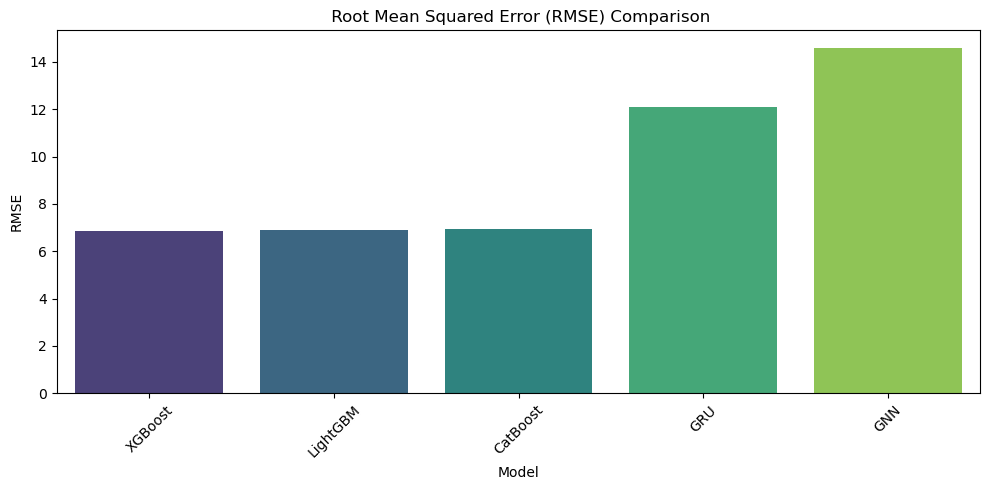

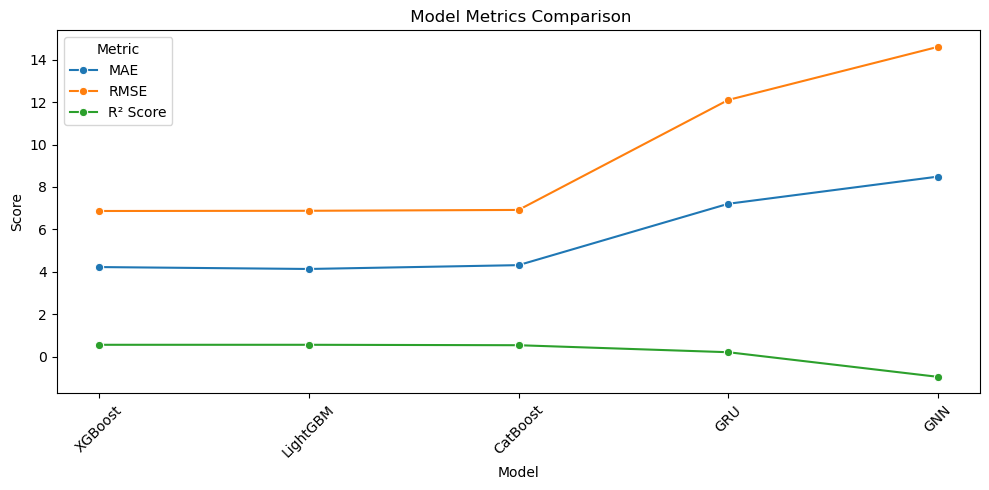

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample performance dictionary – replace with your actual result dictionaries
model_results = {
    'XGBoost': {'MAE': 4.23, 'RMSE': 6.87, 'R2': 0.57},
    'LightGBM': {'MAE': 4.14, 'RMSE': 6.88, 'R2': 0.57},
    'CatBoost': {'MAE': 4.32, 'RMSE': 6.92, 'R2': 0.55},
    'GRU': {'MAE': 7.21, 'RMSE': 12.10, 'R2': 0.22},
    'GNN': {'MAE': 8.49, 'RMSE': 14.60, 'R2': -0.94}
}

# Convert to DataFrame
results_df = pd.DataFrame(model_results).T
results_df.columns = ['MAE', 'RMSE', 'R² Score']
results_df = results_df.sort_values(by='RMSE')

#  Print the performance table
print(" Model Evaluation Summary:")
print(results_df)

#  Plot 1: Barplot of RMSE for all models
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df.reset_index(), x='index', y='RMSE', palette='viridis')
plt.title(" Root Mean Squared Error (RMSE) Comparison")
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#  Plot 2: Lineplot of all metrics
results_df.reset_index(inplace=True)
results_df = pd.melt(results_df, id_vars='index', var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 5))
sns.lineplot(data=results_df, x='index', y='Score', hue='Metric', marker='o')
plt.title(" Model Metrics Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()


In [51]:


# Preprocess training data
X, y, label_encoders, scaler = preprocess_data(train_df, is_train=True)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Check if the data is split correctly
print(f"X_train Shape: {X_train.shape}, y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}, y_test Shape: {y_test.shape}")

#  Define LightGBM hyperparameters
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'max_depth': 8,
    'num_leaves': 31,
    'min_data_in_leaf': 10,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'verbosity': -1
}

# Convert Data to LightGBM Dataset Format
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Use `callbacks=[lgb.early_stopping(50)]` instead of `early_stopping_rounds=50`
lgb_model = lgb.train(
    lgb_params,
    train_data,
    num_boost_round=500,  # Equivalent to `n_estimators`
    valid_sets=[valid_data],  # Validation data for early stopping
    callbacks=[lgb.early_stopping(50)],  #  Correct way to apply early stopping
)

print("\nLightGBM Training Completed")

X_train Shape: (4091, 14), y_train Shape: (4091,)
X_test Shape: (1023, 14), y_test Shape: (1023,)
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	valid_0's rmse: 6.88394

LightGBM Training Completed


In [52]:


# Dictionary to store LightGBM results
lgbm_results_by_mode = {}

# Train LightGBM for each shipment mode
for mode in shipment_modes:
    print(f"Training LightGBM for Shipment Mode: {mode}")

    # Filter data
    X_train_mode = X_train[X_train['shipment_mode'] == mode].drop(columns=['shipment_mode'])
    y_train_mode = y_train[X_train['shipment_mode'] == mode]
    X_test_mode = X_test[X_test['shipment_mode'] == mode].drop(columns=['shipment_mode'], errors='ignore')

    # Train LightGBM model
    lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.05, max_depth=8, random_state=42)
    lgbm_model.fit(X_train_mode, y_train_mode)

    # Predict on test set
    y_pred_lgbm = lgbm_model.predict(X_test_mode)

    # Predict on train set for evaluation
    y_train_pred_lgbm = lgbm_model.predict(X_train_mode)

    # Evaluate performance
    lgbm_mae = mean_absolute_error(y_train_mode, y_train_pred_lgbm)
    lgbm_rmse = mean_squared_error(y_train_mode, y_train_pred_lgbm) ** 0.5
    lgbm_r2 = r2_score(y_train_mode, y_train_pred_lgbm)

    # Store results
    lgbm_results_by_mode[mode] = {
        "MAE": lgbm_mae,
        "RMSE": lgbm_rmse,
        "R2 Score": lgbm_r2,
        "Predictions": y_pred_lgbm[:10]
    }

# Convert results to DataFrame and display
lgbm_results_df = pd.DataFrame(lgbm_results_by_mode).T
print("LightGBM Results:")
print(lgbm_results_df)



Training LightGBM for Shipment Mode: 0
Training LightGBM for Shipment Mode: 1
LightGBM Results:
        MAE      RMSE  R2 Score  \
0  0.079553  0.093871  0.418991   
1  5.986132   7.14014  0.454698   

                                         Predictions  
0  [5.108996535358475, 5.257333821155722, 5.19553...  
1  [21.68129855299087, 25.905560794701522, 21.352...  


In [53]:
y_pred_lgbm = lgb_model.predict(X_test)

In [54]:

lgbm_mae = mean_absolute_error(y_test, y_pred_lgbm)
lgbm_rmse = mean_squared_error(y_test, y_pred_lgbm) ** 0.5
lgbm_r2 = r2_score(y_test, y_pred_lgbm)

print(f"LightGBM Performance: \nMAE: {lgbm_mae:.4f} \nRMSE: {lgbm_rmse:.4f} \nR² Score: {lgbm_r2:.4f}")


LightGBM Performance: 
MAE: 4.1422 
RMSE: 6.8839 
R² Score: 0.5683


In [55]:


# Define the objective function for Optuna
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'max_depth': trial.suggest_int('max_depth', 6, 16),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.7, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 1.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 1.0),
        'n_estimators': 300,  # Keeping fixed
        'random_state': 42
    }

    # Train LightGBM model
    lgb_model = LGBMRegressor(**params)
    lgb_model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        callbacks=[
            lgb.early_stopping(50),  #  Correct early stopping
            lgb.log_evaluation(50)   #  Fix: Use `log_evaluation()` instead of `verbose`
        ]
    )

    # Predict on the test set
    y_pred = lgb_model.predict(X_test)
    return mean_squared_error(y_test, y_pred) ** 0.5  # Return RMSE

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Display best parameters
print("Best Parameters Found:")
print(study.best_params)


[I 2025-04-04 06:12:43,259] A new study created in memory with name: no-name-a04d4c42-5388-4238-8e66-b9bb5300fcbd


Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 55.325
[100]	valid_0's l2: 46.86
[150]	valid_0's l2: 45.8212
[200]	valid_0's l2: 45.6333
[250]	valid_0's l2: 45.7573
Early stopping, best iteration is:
[205]	valid_0's l2: 45.6161


[I 2025-04-04 06:12:43,442] Trial 0 finished with value: 6.753971118505667 and parameters: {'learning_rate': 0.01876660847387912, 'max_depth': 6, 'num_leaves': 55, 'feature_fraction': 0.775868016005888, 'bagging_fraction': 0.8642567642159396, 'lambda_l1': 0.14885362692302462, 'lambda_l2': 0.3697867502981832}. Best is trial 0 with value: 6.753971118505667.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 83.2703
[100]	valid_0's l2: 67.8267
[150]	valid_0's l2: 58.5989
[200]	valid_0's l2: 53.099
[250]	valid_0's l2: 49.9643
[300]	valid_0's l2: 48.1829
Did not meet early stopping. Best iteration is:
[300]	valid_0's l2: 48.1829


[I 2025-04-04 06:12:43,735] Trial 1 finished with value: 6.9413910601103925 and parameters: {'learning_rate': 0.005361441464338078, 'max_depth': 15, 'num_leaves': 22, 'feature_fraction': 0.9903532594315582, 'bagging_fraction': 0.7285585387090426, 'lambda_l1': 0.5072527825958288, 'lambda_l2': 0.3976900941552024}. Best is trial 0 with value: 6.753971118505667.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 47.8843


[I 2025-04-04 06:12:43,903] Trial 2 finished with value: 6.915303447869607 and parameters: {'learning_rate': 0.054684197251457005, 'max_depth': 16, 'num_leaves': 41, 'feature_fraction': 0.9823038649396006, 'bagging_fraction': 0.7624699674151922, 'lambda_l1': 0.0790470574229496, 'lambda_l2': 0.3262059302647964}. Best is trial 0 with value: 6.753971118505667.


[100]	valid_0's l2: 49.0511
Early stopping, best iteration is:
[57]	valid_0's l2: 47.8214
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 46.5915


[I 2025-04-04 06:12:43,994] Trial 3 finished with value: 6.801881503058485 and parameters: {'learning_rate': 0.06853090180412766, 'max_depth': 8, 'num_leaves': 97, 'feature_fraction': 0.7027850525368378, 'bagging_fraction': 0.7334387551284348, 'lambda_l1': 0.3140980186526988, 'lambda_l2': 0.5591734404177027}. Best is trial 0 with value: 6.753971118505667.


Early stopping, best iteration is:
[43]	valid_0's l2: 46.2656
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 47.0889
Early stopping, best iteration is:
[27]	valid_0's l2: 46.5387


[I 2025-04-04 06:12:44,080] Trial 4 finished with value: 6.821930773858034 and parameters: {'learning_rate': 0.09908861582046413, 'max_depth': 9, 'num_leaves': 36, 'feature_fraction': 0.8156513863899229, 'bagging_fraction': 0.9789516289584296, 'lambda_l1': 0.9683417467139233, 'lambda_l2': 0.6100222424246584}. Best is trial 0 with value: 6.753971118505667.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 83.8579
[100]	valid_0's l2: 68.4641
[150]	valid_0's l2: 59.3612
[200]	valid_0's l2: 53.8575
[250]	valid_0's l2: 50.7861
[300]	valid_0's l2: 48.9738
Did not meet early stopping. Best iteration is:
[300]	valid_0's l2: 48.9738


[I 2025-04-04 06:12:44,542] Trial 5 finished with value: 6.998127282694731 and parameters: {'learning_rate': 0.005217911940524443, 'max_depth': 11, 'num_leaves': 54, 'feature_fraction': 0.8945289531339249, 'bagging_fraction': 0.7577530745717457, 'lambda_l1': 0.5004343835176586, 'lambda_l2': 0.5708097000739596}. Best is trial 0 with value: 6.753971118505667.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 77.3498
[100]	valid_0's l2: 61.289
[150]	valid_0's l2: 53.3708
[200]	valid_0's l2: 49.5796
[250]	valid_0's l2: 47.7886
[300]	valid_0's l2: 47.0439
Did not meet early stopping. Best iteration is:
[300]	valid_0's l2: 47.0439


[I 2025-04-04 06:12:44,894] Trial 6 finished with value: 6.858854624403103 and parameters: {'learning_rate': 0.007068355177296825, 'max_depth': 9, 'num_leaves': 55, 'feature_fraction': 0.8013402412946932, 'bagging_fraction': 0.7998419231151922, 'lambda_l1': 0.994834795806774, 'lambda_l2': 0.3721416966797555}. Best is trial 0 with value: 6.753971118505667.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 47.0419


[I 2025-04-04 06:12:45,057] Trial 7 finished with value: 6.8543134143093525 and parameters: {'learning_rate': 0.04623736840079024, 'max_depth': 12, 'num_leaves': 60, 'feature_fraction': 0.7568252893706537, 'bagging_fraction': 0.8330710054564577, 'lambda_l1': 0.3301797251033024, 'lambda_l2': 0.7793131795955692}. Best is trial 0 with value: 6.753971118505667.


[100]	valid_0's l2: 48.2672
Early stopping, best iteration is:
[54]	valid_0's l2: 46.9816
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 46.5209
[100]	valid_0's l2: 47.6088
Early stopping, best iteration is:
[50]	valid_0's l2: 46.5209


[I 2025-04-04 06:12:45,221] Trial 8 finished with value: 6.820621353408608 and parameters: {'learning_rate': 0.04701159114602562, 'max_depth': 10, 'num_leaves': 79, 'feature_fraction': 0.7382830790424137, 'bagging_fraction': 0.8001861714512886, 'lambda_l1': 0.06049491379908123, 'lambda_l2': 0.11594458969623633}. Best is trial 0 with value: 6.753971118505667.
[I 2025-04-04 06:12:45,299] Trial 9 finished with value: 6.799727078315619 and parameters: {'learning_rate': 0.098229259411229, 'max_depth': 8, 'num_leaves': 33, 'feature_fraction': 0.7488244339896863, 'bagging_fraction': 0.8267812057599608, 'lambda_l1': 0.44596868249181043, 'lambda_l2': 0.19926676275782318}. Best is trial 0 with value: 6.753971118505667.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 46.9282
Early stopping, best iteration is:
[27]	valid_0's l2: 46.2363
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 49.9799
[100]	valid_0's l2: 46.1755


[I 2025-04-04 06:12:45,476] Trial 10 finished with value: 6.7741536354535565 and parameters: {'learning_rate': 0.027083696282076547, 'max_depth': 6, 'num_leaves': 79, 'feature_fraction': 0.882695760978816, 'bagging_fraction': 0.6045038234784087, 'lambda_l1': 0.7427764884265361, 'lambda_l2': 0.9887747163741157}. Best is trial 0 with value: 6.753971118505667.


[150]	valid_0's l2: 46.0164
Early stopping, best iteration is:
[135]	valid_0's l2: 45.8892
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 49.0159
[100]	valid_0's l2: 46.2216
[150]	valid_0's l2: 46.2198
Early stopping, best iteration is:
[119]	valid_0's l2: 46.0096


[I 2025-04-04 06:12:45,653] Trial 11 finished with value: 6.783037834206175 and parameters: {'learning_rate': 0.029494620960205595, 'max_depth': 6, 'num_leaves': 78, 'feature_fraction': 0.8820670390003462, 'bagging_fraction': 0.6056479246426247, 'lambda_l1': 0.6940498505815518, 'lambda_l2': 0.9560623889833877}. Best is trial 0 with value: 6.753971118505667.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 50.3018
[100]	valid_0's l2: 46.138


[I 2025-04-04 06:12:45,855] Trial 12 finished with value: 6.765095137051108 and parameters: {'learning_rate': 0.02618744467651806, 'max_depth': 6, 'num_leaves': 75, 'feature_fraction': 0.9296588928788866, 'bagging_fraction': 0.923159779214694, 'lambda_l1': 0.7548697360167222, 'lambda_l2': 0.9512541060198318}. Best is trial 0 with value: 6.753971118505667.


[150]	valid_0's l2: 45.9189
Early stopping, best iteration is:
[130]	valid_0's l2: 45.7665
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 49.2038
[100]	valid_0's l2: 46.3801
[150]	valid_0's l2: 46.3428


[I 2025-04-04 06:12:46,057] Trial 13 finished with value: 6.8064678079219485 and parameters: {'learning_rate': 0.02889931923521212, 'max_depth': 6, 'num_leaves': 69, 'feature_fraction': 0.9361926667655791, 'bagging_fraction': 0.9325439252295475, 'lambda_l1': 0.7433926559567456, 'lambda_l2': 0.7405578486770872}. Best is trial 0 with value: 6.753971118505667.


Early stopping, best iteration is:
[146]	valid_0's l2: 46.328
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 54.1899
[100]	valid_0's l2: 47.2495
[150]	valid_0's l2: 46.9061
Early stopping, best iteration is:
[121]	valid_0's l2: 46.8039


[I 2025-04-04 06:12:46,397] Trial 14 finished with value: 6.8413384641463475 and parameters: {'learning_rate': 0.020307128474980937, 'max_depth': 13, 'num_leaves': 96, 'feature_fraction': 0.8261768183827383, 'bagging_fraction': 0.8989615729324784, 'lambda_l1': 0.20974758219614492, 'lambda_l2': 0.7737781035747056}. Best is trial 0 with value: 6.753971118505667.
[I 2025-04-04 06:12:46,610] Trial 15 finished with value: 6.77965765606048 and parameters: {'learning_rate': 0.021132396409038336, 'max_depth': 7, 'num_leaves': 46, 'feature_fraction': 0.9458530108711346, 'bagging_fraction': 0.8865711316117431, 'lambda_l1': 0.6374645785166373, 'lambda_l2': 0.009168759914408353}. Best is trial 0 with value: 6.753971118505667.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 53.4751
[100]	valid_0's l2: 46.6138
[150]	valid_0's l2: 45.9638
[200]	valid_0's l2: 46.1629
Early stopping, best iteration is:
[150]	valid_0's l2: 45.9638
Training until validation scores don't improve for 50 rounds


[I 2025-04-04 06:12:46,767] Trial 16 finished with value: 6.773971400541966 and parameters: {'learning_rate': 0.04012551847688889, 'max_depth': 8, 'num_leaves': 68, 'feature_fraction': 0.7779090368008748, 'bagging_fraction': 0.9823527213158878, 'lambda_l1': 0.8476767338679922, 'lambda_l2': 0.2866402676270278}. Best is trial 0 with value: 6.753971118505667.


[50]	valid_0's l2: 46.7397
[100]	valid_0's l2: 46.443
Early stopping, best iteration is:
[69]	valid_0's l2: 45.8867
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 45.9334
[100]	valid_0's l2: 46.4787
Early stopping, best iteration is:
[59]	valid_0's l2: 45.8031


[I 2025-04-04 06:12:46,925] Trial 17 finished with value: 6.767800491325511 and parameters: {'learning_rate': 0.059555235431572505, 'max_depth': 7, 'num_leaves': 69, 'feature_fraction': 0.8506927073987994, 'bagging_fraction': 0.8779589447820737, 'lambda_l1': 0.20588426334724352, 'lambda_l2': 0.4733469426593769}. Best is trial 0 with value: 6.753971118505667.
[I 2025-04-04 06:12:47,124] Trial 18 finished with value: 6.899183994680238 and parameters: {'learning_rate': 0.07731306165957376, 'max_depth': 14, 'num_leaves': 87, 'feature_fraction': 0.9374877432933088, 'bagging_fraction': 0.9257007490020807, 'lambda_l1': 0.6154293257006274, 'lambda_l2': 0.8758715715509701}. Best is trial 0 with value: 6.753971118505667.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 48.4124
Early stopping, best iteration is:
[32]	valid_0's l2: 47.5987
Training until validation scores don't improve for 50 rounds


[I 2025-04-04 06:12:47,314] Trial 19 finished with value: 6.833080102280919 and parameters: {'learning_rate': 0.03738282176047886, 'max_depth': 11, 'num_leaves': 50, 'feature_fraction': 0.8514105267546859, 'bagging_fraction': 0.8557690554281977, 'lambda_l1': 0.8297221599744026, 'lambda_l2': 0.6349790382877716}. Best is trial 0 with value: 6.753971118505667.


[50]	valid_0's l2: 47.267
[100]	valid_0's l2: 47.0086
Early stopping, best iteration is:
[66]	valid_0's l2: 46.691
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 58.3189
[100]	valid_0's l2: 47.9873


[I 2025-04-04 06:12:47,538] Trial 20 finished with value: 6.775170370473568 and parameters: {'learning_rate': 0.0160152526957223, 'max_depth': 7, 'num_leaves': 63, 'feature_fraction': 0.7126154178516589, 'bagging_fraction': 0.9423578650322567, 'lambda_l1': 0.39885607402780704, 'lambda_l2': 0.4578487122354959}. Best is trial 0 with value: 6.753971118505667.


[150]	valid_0's l2: 46.1301
[200]	valid_0's l2: 45.9116
Early stopping, best iteration is:
[191]	valid_0's l2: 45.9029
Training until validation scores don't improve for 50 rounds


[I 2025-04-04 06:12:47,707] Trial 21 finished with value: 6.7481196607896665 and parameters: {'learning_rate': 0.06336282599226237, 'max_depth': 7, 'num_leaves': 71, 'feature_fraction': 0.8584344325989987, 'bagging_fraction': 0.8744030037710822, 'lambda_l1': 0.1756750375168903, 'lambda_l2': 0.4889233472792889}. Best is trial 21 with value: 6.7481196607896665.
[I 2025-04-04 06:12:47,839] Trial 22 finished with value: 6.792368522974308 and parameters: {'learning_rate': 0.07976270424352613, 'max_depth': 6, 'num_leaves': 87, 'feature_fraction': 0.9112394967759693, 'bagging_fraction': 0.8981752840879547, 'lambda_l1': 0.16709590482164693, 'lambda_l2': 0.21249991340304636}. Best is trial 21 with value: 6.7481196607896665.


[50]	valid_0's l2: 45.6363
Early stopping, best iteration is:
[47]	valid_0's l2: 45.5371
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 46.4684
Early stopping, best iteration is:
[35]	valid_0's l2: 46.1363


[I 2025-04-04 06:12:48,040] Trial 23 finished with value: 6.771899355604896 and parameters: {'learning_rate': 0.06552000697833348, 'max_depth': 7, 'num_leaves': 74, 'feature_fraction': 0.7945535296416492, 'bagging_fraction': 0.8524410590801663, 'lambda_l1': 0.009309791402793338, 'lambda_l2': 0.6814845081486913}. Best is trial 21 with value: 6.7481196607896665.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 45.8586
[100]	valid_0's l2: 46.4944
Early stopping, best iteration is:
[50]	valid_0's l2: 45.8586
Training until validation scores don't improve for 50 rounds


[I 2025-04-04 06:12:48,254] Trial 24 finished with value: 6.829976957548684 and parameters: {'learning_rate': 0.036890542819380326, 'max_depth': 9, 'num_leaves': 89, 'feature_fraction': 0.8404776733002541, 'bagging_fraction': 0.9557264923755722, 'lambda_l1': 0.275544677489991, 'lambda_l2': 0.5157453789304105}. Best is trial 21 with value: 6.7481196607896665.


[50]	valid_0's l2: 47.4053
[100]	valid_0's l2: 46.934
Early stopping, best iteration is:
[81]	valid_0's l2: 46.6486
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 61.2539
[100]	valid_0's l2: 49.2906


[I 2025-04-04 06:12:48,533] Trial 25 finished with value: 6.782920233283971 and parameters: {'learning_rate': 0.014336053541153533, 'max_depth': 6, 'num_leaves': 63, 'feature_fraction': 0.9585090768270974, 'bagging_fraction': 0.6521128036165136, 'lambda_l1': 0.12707213922587146, 'lambda_l2': 0.43823207862075747}. Best is trial 21 with value: 6.7481196607896665.


[150]	valid_0's l2: 46.5787
[200]	valid_0's l2: 46.1365
[250]	valid_0's l2: 46.0278
Early stopping, best iteration is:
[249]	valid_0's l2: 46.008


[I 2025-04-04 06:12:48,717] Trial 26 finished with value: 6.781155951665885 and parameters: {'learning_rate': 0.07392321180569734, 'max_depth': 8, 'num_leaves': 56, 'feature_fraction': 0.863055496150441, 'bagging_fraction': 0.9996524653321688, 'lambda_l1': 0.554723369109912, 'lambda_l2': 0.25993949904042774}. Best is trial 21 with value: 6.7481196607896665.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 46.5643
Early stopping, best iteration is:
[39]	valid_0's l2: 45.9841
Training until validation scores don't improve for 50 rounds


[I 2025-04-04 06:12:48,877] Trial 27 finished with value: 6.874668655902188 and parameters: {'learning_rate': 0.08774595659864885, 'max_depth': 10, 'num_leaves': 76, 'feature_fraction': 0.9147623457959845, 'bagging_fraction': 0.9167203663263209, 'lambda_l1': 0.3911540712802441, 'lambda_l2': 0.9050009497977327}. Best is trial 21 with value: 6.7481196607896665.


[50]	valid_0's l2: 47.8078
Early stopping, best iteration is:
[36]	valid_0's l2: 47.2611
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 45.8019
[100]	valid_0's l2: 46.5869
Early stopping, best iteration is:
[53]	valid_0's l2: 45.7094


[I 2025-04-04 06:12:49,011] Trial 28 finished with value: 6.760869400377494 and parameters: {'learning_rate': 0.060521102158528906, 'max_depth': 7, 'num_leaves': 47, 'feature_fraction': 0.7782405793906196, 'bagging_fraction': 0.8662212077610995, 'lambda_l1': 0.23030122229363317, 'lambda_l2': 0.37048431314209335}. Best is trial 21 with value: 6.7481196607896665.
[I 2025-04-04 06:12:49,152] Trial 29 finished with value: 6.7652664376097995 and parameters: {'learning_rate': 0.056898672422533714, 'max_depth': 10, 'num_leaves': 23, 'feature_fraction': 0.7847880231953845, 'bagging_fraction': 0.8138884746913508, 'lambda_l1': 0.22689461082562146, 'lambda_l2': 0.38624200824058325}. Best is trial 21 with value: 6.7481196607896665.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 45.806
Early stopping, best iteration is:
[45]	valid_0's l2: 45.7688
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 46.1161


[I 2025-04-04 06:12:49,351] Trial 30 finished with value: 6.7741424126093355 and parameters: {'learning_rate': 0.04691958005040157, 'max_depth': 7, 'num_leaves': 45, 'feature_fraction': 0.7704750073553449, 'bagging_fraction': 0.8611862113634199, 'lambda_l1': 0.0061519598013216326, 'lambda_l2': 0.11948908421772919}. Best is trial 21 with value: 6.7481196607896665.


[100]	valid_0's l2: 46.3838
Early stopping, best iteration is:
[72]	valid_0's l2: 45.889
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 46.0874
Early stopping, best iteration is:
[45]	valid_0's l2: 45.8296


[I 2025-04-04 06:12:49,515] Trial 31 finished with value: 6.769753858853386 and parameters: {'learning_rate': 0.06422349369598665, 'max_depth': 7, 'num_leaves': 60, 'feature_fraction': 0.7330814345969545, 'bagging_fraction': 0.8760888537454965, 'lambda_l1': 0.12827842684294685, 'lambda_l2': 0.4140542756720824}. Best is trial 21 with value: 6.7481196607896665.
[I 2025-04-04 06:12:49,722] Trial 32 finished with value: 6.7794078545474346 and parameters: {'learning_rate': 0.0518698218858351, 'max_depth': 6, 'num_leaves': 49, 'feature_fraction': 0.9970567593448676, 'bagging_fraction': 0.8400634579441681, 'lambda_l1': 0.27201310181324023, 'lambda_l2': 0.31269158880424225}. Best is trial 21 with value: 6.7481196607896665.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 46.1922
[100]	valid_0's l2: 46.318
Early stopping, best iteration is:
[72]	valid_0's l2: 45.9604
Training until validation scores don't improve for 50 rounds


[I 2025-04-04 06:12:49,889] Trial 33 finished with value: 6.853053817075905 and parameters: {'learning_rate': 0.060805043832077826, 'max_depth': 8, 'num_leaves': 41, 'feature_fraction': 0.9750150216602872, 'bagging_fraction': 0.7829253733505326, 'lambda_l1': 0.08818363102234905, 'lambda_l2': 0.5176441900688848}. Best is trial 21 with value: 6.7481196607896665.


[50]	valid_0's l2: 47.0857
[100]	valid_0's l2: 48.0434
Early stopping, best iteration is:
[57]	valid_0's l2: 46.9643
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 45.6121


[I 2025-04-04 06:12:50,065] Trial 34 finished with value: 6.747184006591148 and parameters: {'learning_rate': 0.06870257576062269, 'max_depth': 16, 'num_leaves': 30, 'feature_fraction': 0.8208234579635624, 'bagging_fraction': 0.9080066082306656, 'lambda_l1': 0.35640682538553775, 'lambda_l2': 0.3702242545086859}. Best is trial 34 with value: 6.747184006591148.


Early stopping, best iteration is:
[49]	valid_0's l2: 45.5245
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 46.1588
Early stopping, best iteration is:
[42]	valid_0's l2: 45.9556


[I 2025-04-04 06:12:50,247] Trial 35 finished with value: 6.779055146087318 and parameters: {'learning_rate': 0.07032300248473307, 'max_depth': 16, 'num_leaves': 27, 'feature_fraction': 0.809977210805676, 'bagging_fraction': 0.7033427960619545, 'lambda_l1': 0.33487831501301857, 'lambda_l2': 0.353532928846954}. Best is trial 34 with value: 6.747184006591148.
[I 2025-04-04 06:12:50,417] Trial 36 finished with value: 6.799291269275301 and parameters: {'learning_rate': 0.08447056628556139, 'max_depth': 15, 'num_leaves': 35, 'feature_fraction': 0.8266965046224377, 'bagging_fraction': 0.9056431435332865, 'lambda_l1': 0.26773915588184427, 'lambda_l2': 0.5755644669505302}. Best is trial 34 with value: 6.747184006591148.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 46.7448
Early stopping, best iteration is:
[34]	valid_0's l2: 46.2304
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 46.0662


[I 2025-04-04 06:12:50,576] Trial 37 finished with value: 6.772151422351057 and parameters: {'learning_rate': 0.052436013944416625, 'max_depth': 15, 'num_leaves': 31, 'feature_fraction': 0.7966173297523231, 'bagging_fraction': 0.957220267706503, 'lambda_l1': 0.3813419996751207, 'lambda_l2': 0.35763018229959576}. Best is trial 34 with value: 6.747184006591148.
[I 2025-04-04 06:12:50,737] Trial 38 finished with value: 6.81729125791339 and parameters: {'learning_rate': 0.0711008823467451, 'max_depth': 13, 'num_leaves': 41, 'feature_fraction': 0.7591632079771808, 'bagging_fraction': 0.7800501984169761, 'lambda_l1': 0.15805711447421922, 'lambda_l2': 0.23591437603233295}. Best is trial 34 with value: 6.747184006591148.


[100]	valid_0's l2: 46.7933
Early stopping, best iteration is:
[56]	valid_0's l2: 45.862
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 46.9418
Early stopping, best iteration is:
[39]	valid_0's l2: 46.4755


[I 2025-04-04 06:12:50,916] Trial 39 finished with value: 6.832086908875395 and parameters: {'learning_rate': 0.09000014799104458, 'max_depth': 12, 'num_leaves': 40, 'feature_fraction': 0.8151026496656614, 'bagging_fraction': 0.865137277725713, 'lambda_l1': 0.434311107573264, 'lambda_l2': 0.5117942932732396}. Best is trial 34 with value: 6.747184006591148.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 47.8024
Early stopping, best iteration is:
[32]	valid_0's l2: 46.6774
Training until validation scores don't improve for 50 rounds


[I 2025-04-04 06:12:51,082] Trial 40 finished with value: 6.753527089189279 and parameters: {'learning_rate': 0.06425502419955312, 'max_depth': 9, 'num_leaves': 20, 'feature_fraction': 0.8287548148690409, 'bagging_fraction': 0.7330808883297018, 'lambda_l1': 0.323664221070133, 'lambda_l2': 0.1583113685131613}. Best is trial 34 with value: 6.747184006591148.


[50]	valid_0's l2: 45.6101
[100]	valid_0's l2: 46.3509
Early stopping, best iteration is:
[50]	valid_0's l2: 45.6101
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 45.5005
[100]	valid_0's l2: 45.9649
Early stopping, best iteration is:
[50]	valid_0's l2: 45.5005


[I 2025-04-04 06:12:51,222] Trial 41 finished with value: 6.745403668665684 and parameters: {'learning_rate': 0.06537575194489723, 'max_depth': 9, 'num_leaves': 20, 'feature_fraction': 0.837475186824348, 'bagging_fraction': 0.7242892139639507, 'lambda_l1': 0.33560140361466395, 'lambda_l2': 0.1602829481285089}. Best is trial 41 with value: 6.745403668665684.
[I 2025-04-04 06:12:51,355] Trial 42 finished with value: 6.787384233220964 and parameters: {'learning_rate': 0.06602051074442826, 'max_depth': 9, 'num_leaves': 20, 'feature_fraction': 0.8721065637514532, 'bagging_fraction': 0.7327576682201392, 'lambda_l1': 0.33264775351242803, 'lambda_l2': 0.16005644327635696}. Best is trial 41 with value: 6.745403668665684.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 46.1893
Early stopping, best iteration is:
[44]	valid_0's l2: 46.0686
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 46.5903
Early stopping, best iteration is:
[31]	valid_0's l2: 46.0109


[I 2025-04-04 06:12:51,491] Trial 43 finished with value: 6.78313589992818 and parameters: {'learning_rate': 0.07716691990511439, 'max_depth': 9, 'num_leaves': 26, 'feature_fraction': 0.8276488548021824, 'bagging_fraction': 0.6921964145274293, 'lambda_l1': 0.4977754016664503, 'lambda_l2': 0.009054724006480525}. Best is trial 41 with value: 6.745403668665684.
[I 2025-04-04 06:12:51,692] Trial 44 finished with value: 6.75095230515867 and parameters: {'learning_rate': 0.05372206632606481, 'max_depth': 10, 'num_leaves': 29, 'feature_fraction': 0.842290508796875, 'bagging_fraction': 0.7493917509119612, 'lambda_l1': 0.3066705038247932, 'lambda_l2': 0.06959159253872317}. Best is trial 41 with value: 6.745403668665684.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 45.7915
[100]	valid_0's l2: 46.1934
Early stopping, best iteration is:
[68]	valid_0's l2: 45.5754
Training until validation scores don't improve for 50 rounds


[I 2025-04-04 06:12:51,860] Trial 45 finished with value: 6.801433416488736 and parameters: {'learning_rate': 0.05101014300627137, 'max_depth': 10, 'num_leaves': 28, 'feature_fraction': 0.84434735748898, 'bagging_fraction': 0.7475726679120398, 'lambda_l1': 0.30000399382138543, 'lambda_l2': 0.06105418194614495}. Best is trial 41 with value: 6.745403668665684.


[50]	valid_0's l2: 46.3102
Early stopping, best iteration is:
[48]	valid_0's l2: 46.2595
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 45.8977
[100]	valid_0's l2: 46.3768
Early stopping, best iteration is:
[62]	valid_0's l2: 45.7983


[I 2025-04-04 06:12:52,009] Trial 46 finished with value: 6.767440516048892 and parameters: {'learning_rate': 0.0570021021595054, 'max_depth': 11, 'num_leaves': 23, 'feature_fraction': 0.8623555893487432, 'bagging_fraction': 0.7038529037780511, 'lambda_l1': 0.3588956039935724, 'lambda_l2': 0.08915551765107815}. Best is trial 41 with value: 6.745403668665684.
[I 2025-04-04 06:12:52,165] Trial 47 finished with value: 6.77192181655742 and parameters: {'learning_rate': 0.06815604503906075, 'max_depth': 9, 'num_leaves': 31, 'feature_fraction': 0.8364043633923232, 'bagging_fraction': 0.6615986248166186, 'lambda_l1': 0.4241135635849704, 'lambda_l2': 0.1487376589005321}. Best is trial 41 with value: 6.745403668665684.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 46.0925
Early stopping, best iteration is:
[35]	valid_0's l2: 45.8589
Training until validation scores don't improve for 50 rounds


[I 2025-04-04 06:12:52,336] Trial 48 finished with value: 6.739535882874794 and parameters: {'learning_rate': 0.06251580236043426, 'max_depth': 12, 'num_leaves': 20, 'feature_fraction': 0.8952960871922747, 'bagging_fraction': 0.7659191186499161, 'lambda_l1': 0.47797436813921823, 'lambda_l2': 0.1760151517917759}. Best is trial 48 with value: 6.739535882874794.


[50]	valid_0's l2: 45.5483
[100]	valid_0's l2: 46.3548
Early stopping, best iteration is:
[53]	valid_0's l2: 45.4213
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 46.8086


[I 2025-04-04 06:12:52,523] Trial 49 finished with value: 6.826259914645867 and parameters: {'learning_rate': 0.045167791992486814, 'max_depth': 12, 'num_leaves': 37, 'feature_fraction': 0.8963704634299611, 'bagging_fraction': 0.7699696821567114, 'lambda_l1': 0.5505842388935799, 'lambda_l2': 0.05314147678132018}. Best is trial 48 with value: 6.739535882874794.


[100]	valid_0's l2: 47.3944
Early stopping, best iteration is:
[62]	valid_0's l2: 46.5978
Best Parameters Found:
{'learning_rate': 0.06251580236043426, 'max_depth': 12, 'num_leaves': 20, 'feature_fraction': 0.8952960871922747, 'bagging_fraction': 0.7659191186499161, 'lambda_l1': 0.47797436813921823, 'lambda_l2': 0.1760151517917759}


In [56]:
# Dictionary to store CatBoost results
catboost_results_by_mode = {}

# Train CatBoost for each shipment mode
for mode in shipment_modes:
    print(f"Training CatBoost for Shipment Mode: {mode}")

    # Filter data
    X_train_mode = X_train[X_train['shipment_mode'] == mode].drop(columns=['shipment_mode'])
    y_train_mode = y_train[X_train['shipment_mode'] == mode]
    X_test_mode = X_test[X_test['shipment_mode'] == mode].drop(columns=['shipment_mode'], errors='ignore')

    # Train CatBoost model
    catboost_model = CatBoostRegressor(n_estimators=200, learning_rate=0.05, depth=8, random_state=42, verbose=0)
    catboost_model.fit(X_train_mode, y_train_mode)

    # Predict on test set
    y_pred_catboost = catboost_model.predict(X_test_mode)

    # Predict on train set for evaluation
    y_train_pred_catboost = catboost_model.predict(X_train_mode)

    # Evaluate performance
    catboost_mae = mean_absolute_error(y_train_mode, y_train_pred_catboost)
    catboost_rmse = mean_squared_error(y_train_mode, y_train_pred_catboost) ** 0.5
    catboost_r2 = r2_score(y_train_mode, y_train_pred_catboost)

    # Store results
    catboost_results_by_mode[mode] = {
        "MAE": catboost_mae,
        "RMSE": catboost_rmse,
        "R2 Score": catboost_r2,
        "Predictions": y_pred_catboost[:10]
    }

# Convert results to DataFrame and display
catboost_results_df = pd.DataFrame(catboost_results_by_mode).T
print("CatBoost Results:")
print(catboost_results_df)


Training CatBoost for Shipment Mode: 0
Training CatBoost for Shipment Mode: 1
CatBoost Results:
        MAE      RMSE  R2 Score  \
0  0.084818  0.099172  0.351516   
1  6.407238   7.61806  0.379256   

                                         Predictions  
0  [5.139936693333889, 5.231611806921118, 5.24510...  
1  [18.840295746303937, 24.8982681742756, 22.6093...  


In [57]:


# Define the objective function for Optuna
def objective(trial):
    params = {
        'iterations': 300,  # Number of boosting iterations
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'depth': trial.suggest_int('depth', 4, 12),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_strength': trial.suggest_float('random_strength', 0.1, 2.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'od_type': 'Iter',
        'od_wait': 20,
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'verbose': 0
    }

    # Train CatBoost model
    cat_model = CatBoostRegressor(**params, random_seed=42)
    cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=0)

    # Predict on test set
    y_pred = cat_model.predict(X_test)
    return mean_squared_error(y_test, y_pred) ** 0.5  # RMSE

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Display best parameters
print(" Best Parameters Found for CatBoost:")
print(study.best_params)


[I 2025-04-04 06:12:54,623] A new study created in memory with name: no-name-208736b1-8d37-4b67-99d0-06dc1aa13fd7
[I 2025-04-04 06:12:58,845] Trial 0 finished with value: 6.861175939532955 and parameters: {'learning_rate': 0.07328394421654758, 'depth': 12, 'l2_leaf_reg': 2.1873451619335325, 'random_strength': 0.6683699061229252, 'bagging_temperature': 0.171839144406298}. Best is trial 0 with value: 6.861175939532955.
[I 2025-04-04 06:13:03,010] Trial 1 finished with value: 6.828157226182661 and parameters: {'learning_rate': 0.009713504953655326, 'depth': 11, 'l2_leaf_reg': 4.80663429883273, 'random_strength': 1.3877390055286238, 'bagging_temperature': 0.7020389754496457}. Best is trial 1 with value: 6.828157226182661.
[I 2025-04-04 06:13:10,476] Trial 2 finished with value: 6.906511340937925 and parameters: {'learning_rate': 0.04002718097641672, 'depth': 12, 'l2_leaf_reg': 6.356387549014489, 'random_strength': 0.2941564960421642, 'bagging_temperature': 0.29864440268881376}. Best is tri

 Best Parameters Found for CatBoost:
{'learning_rate': 0.06936437222118921, 'depth': 6, 'l2_leaf_reg': 9.487358831566919, 'random_strength': 0.7224926692362129, 'bagging_temperature': 0.7231416899656371}


In [58]:

# Use the best parameters found
best_cat_params = {
    'learning_rate': 0.08571378462450718,
    'depth': 6,
    'l2_leaf_reg': 7.886787210214747,
    'random_strength': 0.45760123155736265,
    'bagging_temperature': 0.4885148315925185,
    'iterations': 300,  # Number of boosting iterations
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'verbose': 50,
    # 'random_seed': 42
}

# Initialize and train CatBoost
cat_model = CatBoostRegressor(**best_cat_params)
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=50)

# Predict on test set
y_pred_cat = cat_model.predict(X_test)

# Evaluate model performance
cat_mae = mean_absolute_error(y_test, y_pred_cat)
cat_rmse = mean_squared_error(y_test, y_pred_cat, squared=False)
cat_r2 = r2_score(y_test, y_pred_cat)

# Display results
print("\n **Final CatBoost Performance:**")
print(f" **RMSE**: {cat_rmse:.4f}")
print(f" **MAE**: {cat_mae:.4f}")
print(f" **R² Score**: {cat_r2:.4f}")


0:	learn: 9.7336012	test: 9.9997538	best: 9.9997538 (0)	total: 4.37ms	remaining: 1.3s
50:	learn: 6.2016908	test: 6.7964241	best: 6.7934572 (44)	total: 142ms	remaining: 691ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 6.793457187
bestIteration = 44

Shrink model to first 45 iterations.

 **Final CatBoost Performance:**
 **RMSE**: 6.7935
 **MAE**: 3.9125
 **R² Score**: 0.5796


In [ ]:
# Define Advanced Bidirectional GRU Model
class AdvancedGRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=1, num_layers=4, dropout=0.3):
        super(AdvancedGRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, dropout=dropout, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Multiply hidden_dim by 2 for bidirectional GRU

    def forward(self, x):
        x = x.unsqueeze(1)  # Add sequence dimension
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # Take last time step output
        return out

# Train Advanced GRU for each shipment mode
advanced_gru_results_by_mode = {}

for mode in shipment_modes:
    print(f"Training Advanced Bidirectional GRU for Shipment Mode: {mode}")

    # Filter data
    X_train_mode = X_train[X_train['shipment_mode'] == mode].drop(columns=['shipment_mode'])
    y_train_mode = y_train[X_train['shipment_mode'] == mode]
    X_test_mode = X_test[X_test['shipment_mode'] == mode].drop(columns=['shipment_mode'], errors='ignore')

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_mode.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_mode.values, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test_mode.values, dtype=torch.float32)

    # Create DataLoader
    batch_size = 16
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Initialize model
    advanced_gru_model = AdvancedGRUModel(input_dim=X_train_mode.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(advanced_gru_model.parameters(), lr=0.0001)

    # Train model
    num_epochs = 100
    for epoch in range(num_epochs):
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = advanced_gru_model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    # Predict on test data
    advanced_gru_model.eval()
    with torch.no_grad():
        y_pred_advanced_gru = advanced_gru_model(X_test_tensor).numpy()

    # Predict on train data for evaluation
    with torch.no_grad():
        y_train_pred_advanced_gru = advanced_gru_model(X_train_tensor).numpy()

    # Evaluate performance
    advanced_gru_mae = mean_absolute_error(y_train_mode, y_train_pred_advanced_gru)
    advanced_gru_rmse = mean_squared_error(y_train_mode, y_train_pred_advanced_gru) ** 0.5
    advanced_gru_r2 = r2_score(y_train_mode, y_train_pred_advanced_gru)

    # Store results
    advanced_gru_results_by_mode[mode] = {
        "MAE": advanced_gru_mae,
        "RMSE": advanced_gru_rmse,
        "R2 Score": advanced_gru_r2,
        "Predictions": y_pred_advanced_gru[:10]
    }

# Convert results to DataFrame
advanced_gru_results_df = pd.DataFrame(advanced_gru_results_by_mode).T
print("Advanced GRU Results:")
print(advanced_gru_results_df)


Training Advanced Bidirectional GRU for Shipment Mode: 0


In [ ]:
class GNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=1, num_layers=2):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.fc(x)
        return x

# Initialize Model
gnn_model = GNNModel(input_dim=X_train.shape[1])
optimizer = optim.Adam(gnn_model.parameters(), lr=0.001)
criterion = nn.MSELoss()


In [ ]:
num_epochs = 50

for epoch in range(num_epochs):
    gnn_model.train()
    optimizer.zero_grad()
    y_pred = gnn_model(data)
    loss = criterion(y_pred.squeeze(), data.y)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{num_epochs} - Loss: {loss.item():.4f}")

print("\n GNN Training Completed!")


In [ ]:
gnn_model.eval()
# Convert X_test to tensor
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

# Create new PyTorch Geometric Data object only for test set
test_data = Data(x=X_test_tensor, edge_index=edge_index)

# Predict only on test data
gnn_model.eval()
with torch.no_grad():
    y_pred_gnn = gnn_model(test_data).squeeze().numpy()


# Evaluate Performance
gnn_mae = mean_absolute_error(y_test, y_pred_gnn)
gnn_rmse = mean_squared_error(y_test, y_pred_gnn, squared=False)
gnn_r2 = r2_score(y_test, y_pred_gnn)

# Display results
print("\n **Final GNN Performance:**")
print(f" **RMSE**: {gnn_rmse:.4f}")
print(f" **MAE**: {gnn_mae:.4f}")
print(f" **R² Score**: {gnn_r2:.4f}")


In [ ]:
from torch_geometric.data import Data
from torch_geometric.nn import knn_graph

#  Step 1: Combine training and test features
X_all = np.concatenate([X_train, X_test], axis=0)

#  Step 2: For the labels, I only have y_train — so I fill y_test with zeros
y_all = np.concatenate([y_train, np.zeros(len(X_test))], axis=0)

#  Step 3: Convert them into PyTorch tensors
x_tensor = torch.tensor(X_all, dtype=torch.float32)
y_tensor = torch.tensor(y_all, dtype=torch.float32)

#  Step 4: Create binary masks to differentiate between training and test sets
train_mask = torch.zeros(x_tensor.size(0), dtype=torch.bool)
test_mask = torch.zeros(x_tensor.size(0), dtype=torch.bool)
train_mask[:len(X_train)] = True
test_mask[len(X_train):] = True

#  Step 5: Construct the graph using k-Nearest Neighbors (this builds edges between nodes)
edge_index = knn_graph(x_tensor, k=5)

#  Step 6: Wrap all data into a single PyTorch Geometric Data object
data = Data(x=x_tensor, y=y_tensor, edge_index=edge_index,
            train_mask=train_mask, test_mask=test_mask)

#  Step 7: Sanity check print statements
print(f"x_tensor shape: {x_tensor.shape}")           # e.g., [6374, 14]
print(f"Model output shape: {gnn_model(data).shape}")  # e.g., [6374, 1]
print(f"train_mask shape: {data.train_mask.shape}")  # e.g., [6374]
print(f"y_tensor shape: {data.y.shape}")             # e.g., [6374]
print(len(X_train), len(y_train))                    # e.g., 5341 5341
print(len(X_test), len(X_test))                      # e.g., 1033 1033

#  Step 8: GNN Training Loop
for epoch in range(num_epochs):
    gnn_model.train()
    optimizer.zero_grad()
    out = gnn_model(data).squeeze()
    
    # Compute loss ONLY on training data (masked)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{num_epochs} - Loss: {loss.item():.4f}")

#  Step 9: GNN Evaluation
gnn_model.eval()
with torch.no_grad():
    out = gnn_model(data).squeeze()
    y_true = data.y[data.test_mask].numpy()
    y_pred = out[data.test_mask].numpy()

#  Step 10: Metrics on test data
gnn_rmse = mean_squared_error(y_true, y_pred, squared=False)
gnn_mae = mean_absolute_error(y_true, y_pred)
gnn_r2 = r2_score(y_true, y_pred)

#  Step 11: Final Result Output
print("\n **Updated GNN Performance:**")
print(f" **RMSE**: {gnn_rmse:.4f}")
print(f" **MAE**: {gnn_mae:.4f}")
print(f" **R² Score**: {gnn_r2:.4f}")
